# Script Overview

This script implements a **Simultaneous Graphical VAR (SGDLM-VAR)** framework to estimate a time-varying sparse VAR($p$) system with pandemic-period dummies. Each equation is run as a univariate DLM that includes both own-lags and cross-lags of all series, then combined via a decouple–recouple VB algorithm with importance-sampling corrections.

Outputs include time-series of sampled coefficient matrices, precision draws, and Weighted VB covariance estimates for each node.

## Introduction to the SGDLM and VAR Extension

This repository extends the **Simultaneous Graphical DLM** of West & Harrison (1997) and Gruber & West (2016) by making **each node an equation of a VAR($p$)** instead of a simple AR(1).  The workflow combines *decoupling* (parallel univariate filters) with *recoupling* (sparse Monte-Carlo fusion) and a Variational Bayes + Importance Sampling (VB-IS) refinement.

---

### 1  State-Space Core  

For every series $j=1,\dots,q$ we work with  

$$
\theta_{j,t}=G_j\,\theta_{j,t-1}+\omega_{j,t},\quad 
\omega_{j,t}\!\sim\!\mathcal N(0,W_j)
$$  

$$
y_{j,t}=F_{j,t}\,\theta_{j,t}+\nu_{j,t},\quad 
\nu_{j,t}\!\sim\!\mathcal N(0,V_{j,t})
$$  

*   $F_{j,t}$ stacks an intercept, $p$ own-lags, $p$ cross-lags for *all* other series, and $d_{\text{covid}}$ pandemic dummies.  
*   A **Minnesota prior** shrinks $\theta_{j,0}$ toward zero with variance $\propto\sigma_j^2$; own-lags follow the empirical AR(1) mean $\rho_j$.  
*   **Discount factors** $(\phi,\gamma)$ evolve the prior:  
    $$V_{j,t|t-1}=C_{j,t-1}+(\phi^{-1}-1)C_{\text{own}}+(\gamma^{-1}-1)C_{\text{sim}}$$

---

### 2  Decoupling — Independent DLM Filtering  

For each node $j$:

1. Build $F_{j,t}$.  
2. Perform one-step Kalman update to obtain $(m_{j,t},P_{j,t})$.  
3. Draw $R$ precisions $\lambda_{j,t}^{(r)}\sim\Gamma(n_j/2,2/(n_js_j))$.  

This gives **naïve marginals** $q_j^{\text{naive}}(\theta_{j,t})$ without ever touching the full VAR dimension.

---

### 3  Recoupling — Sparse Joint Posterior  

The graph $\mathcal G$ specifies contemporaneous parents.  
For each Monte-Carlo replicate $r=1,\dots,R$:

1. Draw $\theta_{j,t}^{(r)}\sim\mathcal N(m_{j,t},P_{j,t}/\lambda_{j,t}^{(r)})$ for every $j$.  
2. Stack into the global vector $\theta_t^{(r)}\in\mathbb R^{p_{\text{total}}}$ and weight by  
   $$\alpha_r\propto\bigl|\det(I-\Gamma_t)\bigr|$$  
   which enforces $\mathcal G$.  
3. Compute block-wise moments  
   * $V_j=\sum_r\alpha_r\,\lambda_{r,j}(\theta_{r,j}-m_j)(\theta_{r,j}-m_j)^\top$  
   * $d_j=\sum_r\alpha_r\,\lambda_{r,j}(\theta_{r,j}-m_j)^\top V_j^{-1}(\theta_{r,j}-m_j)$.  

---

### 4  VB Updates and Importance Sampling  

* **Degrees of freedom** $n_j$ solve  
  $$\log(n_j+p_j-d_j)-\psi(n_j/2)-\log(2E[\lambda_j])+(E\log\lambda_j)-(p_j-d_j)/n_j=0$$
* **Scale** $s_j=(n_j+p_j-d_j)/(n_jE[\lambda_j])$.  
* Iterate VB coordinate updates + IS reweighting until ELBO converges.

---

### 5  Outputs  

* Arrays thetas $RP_total$ and lambdas $Rq$ give joint draws of  
  $$y_t=\sum_{k=1}^p A_{t,k}y_{t-k}+\varepsilon_t,\quad
    \varepsilon_t\sim\mathcal N(0,\Sigma_t).$$  
  Reshape `thetas` to recover the time-varying coefficient matrices $A_{t,k}$.  
* Posterior moments $\{m_t,P_t\}$, forecast densities, and diagnostic plots (trace/histograms) can be generated directly from these draws.

**Bottom line:** decouple small DLMs, recouple with a sparse precision graph, refine by VB-IS → a fully Bayesian, computationally tractable, **time-varying sparse VAR**.  


## Librarys 

In [44]:
import pandas as pd 
import numpy as np
from scipy.stats import gamma
from scipy.stats import multivariate_normal
import warnings

## Data 

In [2]:
warnings.simplefilter("always", DeprecationWarning)
data = pd.read_excel('DATA.xlsx')
dats = data.to_numpy()

y_man = np.log(dats[: , 0]) 
un = -(dats[: , 1]/100)+1 # Proxy GDP 
inf = dats[:,2]/100 # Inflation 
TPM=dats[:,3]/100 # TPM 
T_cap=dats[:,4]/100 # T_Cap
T_col=dats[:,5]/100 # T_Colcap
c_cartera=dats[:,7] 

yy= np.column_stack([ -np.log(np.reciprocal(un)-1), np.log(inf), np.log(TPM), np.log(T_col) , np.log(T_cap), c_cartera/10]) 
q = yy.shape[1]

## matrix of series dependencies
Windx = np.zeros((q,q))
for i in range(1,q):
    Windx[i,0:i] = True
Windx[0,1]=Windx[1,2]= True
Windx

array([[0., 1., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 1., 0.]])

## Create the $F$ matrix, Minnesota style Pior and dummy Prior for pandemic periods 

In [3]:
def Fj_matrix(Y,p,j,Windx):
    """
    Build the design matrix F for series j with p lags and selected predictors.

    This function constructs a matrix of regressors by:
    1. Dropping the first p rows of Y to align lags with current observations.
    2. Creating columns for each lag 1…p of all q series in Y.
    3. Prepending a column of ones for the intercept.
    4. Appending only the “active” predictors for series j based on the boolean mask Windx[j-1].

    Internally, it:
    - Slices Y to get y = Y[p:, :] so that y[t] corresponds to Y[t+p].
    - Initializes F (without intercept) as all ones and then fills each block of q columns
      with the values of Y lagged by i periods.
    - Stacks the intercept, full lag block, and selected columns into one matrix.

    """
    y = Y[p:,:]
    T,q = y.shape
    k=q*p
    F = np.ones((T,k))

    # fill each lag-block: for lag i, copy Y shifted by i
    for i in range(0,p+1):
        if 1+(i-1)*q < 0:
            pass 
        else:

            F[:, ((i-1)*q):(i*q)] = Y[p - i : Y.shape[0] - i, :] # assign lagged values: Y[t+p-i] → F[t, start_col:end_col]

    ones_col = np.ones((T, 1))

    # combine intercept, all lags, and selected predictors
    return np.hstack([ones_col, F, y[:, Windx[j-1, :].astype(bool)]])

covid_periods = 6 # Example
indx_covid = 183 # In what index starts the covid 


def covid_dummy(Y,p,covid_periods,indx_covid):
    """
    Generate pandemic-period dummy variables.

    This function builds a T×covid_periods matrix where T = number of rows
    in Y after dropping the first p observations. Each column i corresponds
    to one pandemic period and has a single 1 at the row that marks the start
    of that period; all other entries remain 0. These dummies can be appended
    as exogenous regressors to capture discrete shocks.

    Returns:
      A numpy array of shape (T, covid_periods) with ones indicating
      the onset of each pandemic period.
    """

    covid_dummy1= np.zeros((Y[p:,:].shape[0], covid_periods))

    # for each pandemic period, set a single 1 at the correct time index
    for i in range(0,covid_periods):
        covid_dummy1[indx_covid + i-2, i]=1 # row = indx_covid + (i - 2) aligns the dummy start with pandemic timing
    return covid_dummy1


def Fj_matrix_covid(Y,p,j,Windx,covid_periods,indx_covid,q):
    """
    Extend the lagged‐regressors matrix by including pandemic‐period dummies.

    This function builds on Fj_matrix by:
      1. Dropping the first p rows of Y to align past values.
      2. Creating the full block of p lags for all q series.
      3. Generating covid dummy columns to capture discrete pandemic shocks.
      4. Appending only the “active” predictors for series j based on Windx[j-1].

    The final matrix has columns:
      [intercept | all lags | covid dummies | selected predictors]
    """

    y = Y[p:,:]
    T,q = y.shape
    k=q*p

    cd19 = covid_dummy(Y,p,covid_periods,indx_covid) # generate pandemic‐period dummy matrix (T × covid_periods)
    F = np.ones((T,k))

    # fill lagged block: for each lag i, shift Y by i periods
    for i in range(0,p+1):
        if 1+(i-1)*q < 0:
            pass 
        else:
            F[:, ((i-1)*q):(i*q)] = Y[p - i : Y.shape[0] - i, :] # assign Y[t+p-i, :] into F[t, start:end]
    ones_col = np.ones((T, 1)) 

    # combine intercept, lags, covid dummies, and active predictors
    return np.hstack([ones_col, F,cd19, y[:, Windx[j-1, :].astype(bool)]]) 


def get_resid_var(Y):
    """
    Estimate first-order autocorrelation and residual variance for each series in Y.

    For each column i in the data matrix Y:
      1. Align two vectors:  
         - y_reg = values from row 4 onward (target)  
         - lagged = values from row 3 up to the penultimate (predictor)
      2. Fit a simple linear regression  
         y_reg = intercept + rho * lagged + error  
      3. Extract:
         - rho_i: the slope coefficient (autocorrelation estimate)
         - sigma2_i: mean squared error of the fit (residual variance)

    Returns:
      sigma2: (q×1) array of residual variances
      rho:    (q×1) array of estimated lag-1 coefficients
    """

    y = Y[4:,:]
    T,q = y.shape
    sigma2 = np.zeros((q,1))
    rho = np.zeros((q,1))

    # loop over each series
    for i in range(0,q):
        Z = np.column_stack((np.ones(T), Y[3:-1, i])) # build design matrix [1, lagged_value]
        y_reg = Y[4:, i]

        tmpb = np.linalg.solve(Z.T @ Z, Z.T @ y_reg) # solve normal equations: beta = (Z'Z)^{-1} Z'y
        rho[i] = tmpb[1] # extract slope (rho_i)

        # compute residuals and their variance
        residual = y_reg - Z @ tmpb
        sigma2[i] = np.mean(residual**2)
    return sigma2 ,rho

s2 ,rho = get_resid_var(yy)


def prior_AM_pp(rho,s2,lamb,covid_periods,Windx,q,p,var_i):
    """
    Construct Minnesota‐style and pandemic‐adjusted priors for one VAR/DLM node.

    This function builds the prior mean vector (m_j) and variance vector (V_j)
    for equation j by combining:
      1. **Intercept prior**: scaled by overall shrinkage λ[0] and diffuse hyperparameter λ[3].
      2. **Minnesota own‐lag prior**: mean = empirical ρ_j, variance ∝ (λ[0]/lag^λ[2])^2.
      3. **Minnesota cross‐lag prior**: variance ∝ (σ_j^2/σ_i^2)·(λ[0]·λ[1]/lag^λ[2])^2.
      4. **Pandemic‐period priors**: extra shrinkage using λ[4] over covid_periods.
      5. **Theoretical priors**: flat priors (variance=0.1) for any remaining parameters.
      6. **Custom mean adjustments**: fixed prior means for selected intercept/dummy terms
         when var_i is 1, 2, or 3.

    Returns:
      mj  : (k_j×1) vector of prior means
      Vj  : (k_j×1) vector of prior variances
      nj  : scalar degrees‐of‐freedom for inverse‐Gamma prior (fixed = 10)
      sj  : empirical variance σ_j^2 for this series
    """

    # count active “parent” regressors for series j
    pyj = int(np.sum(Windx[var_i-1,:]))
    # total number of parameters: intercept + q*p lags + pandemic dummies + active predictors
    kj = pyj + q*p + covid_periods + 1

    mj = np.zeros((int(kj),1))
    Vj = np.zeros((int(kj),1))

    # === Intercept Prior ===
    # The variance of the intercept is assigned in the first position (index 0) of Vj,
    # calculated as the square of the product (lamb[0] * lamb[3]) multiplied by s2 of the variable.
    Vj[0] = ((lamb[0]*lamb[3])**2) * s2[var_i-1]
    mj[var_i-1] = 0 # center intercept at zero
    
    # === Pandemic Prior === 
    # The loop iterates through the indices corresponding to these periods: from (q*p + 2) to (q*p + covid_periods + 1),
    # adjusting the indexing (subtracting 1)
    for i in range(q*p+2, q*p + covid_periods + 2):
        Vj[i-1] = ((lamb[0] * lamb[4])**2) * s2[var_i-1]

    # === Theoretical Priors ===
    # For the remaining parameters (beyond the pandemic periods), a fixed variance of 0.1 is assigned.
    for i in range(q*p + covid_periods + 2 ,int(kj) + 1):
        Vj[i-1] = 0.1

    # Adjustment of the means according to the variable of interest.
    if var_i== 1:
        mj[-1]= 0.75

    elif var_i==2:
        mj[-2]= 0.5
        mj[-1]= -0.5

    elif var_i==3:
        mj[-2]= 0.5
        mj[-1]= 0.75

    ## === Minnesota Prior (Litterman, 1986) ===
    # Adjusts the priors for the lag coefficients (own and cross lags).
    # The first loop iterates over each variable (i in 1..q) and the second over each lag (k in 1..p).
    # Different constraints are imposed for the "own lag" of variable 'var_i'
    # and for the lags of the other variables.
    for i in range(1, q + 1):
        for k in range(1, p + 1):
            index1 = 1 + var_i + (k - 1) * q  
            Vj[index1 - 1] = ((lamb[0] / (k ** lamb[2])) ** 2)

            if k == 1 and i == var_i:
                mj[i] = rho[var_i - 1] # set prior mean to empirical rho for first own‐lag

            if i != var_i:
                index2 = 1 + i + (k - 1) * q  
                Vj[index2 - 1] = (s2[var_i - 1] / s2[i - 1]) * (((lamb[0] * lamb[1]) / (k ** lamb[2])) ** 2) # index for cross‐lag of series i ≠ var_i
    nj=10
    sj=s2[var_i-1]

    return mj,Vj,nj,sj

def full_size(Y,p,Windx,covid_periods,indx_covid,q):
    """
    Compute total number of regression parameters across all q equations.

    This helper iterates over each series index i (0…q-1), calls `Fj_matrix_covid` to
    build the design matrix for equation i, and then counts its columns. Summing these
    counts yields the overall dimension of the global parameter vector θ.
    """
    suma= 0
    for i in range(q):
        matriz = Fj_matrix_covid(Y,p,i,Windx,covid_periods,indx_covid,q)[4,:]
        s1 = matriz.shape[0]
        suma = suma + s1 
    return suma 

# Full prior
def complete_AP(q,p,lambd,s2,rho,covid_periods,Windx,Y):
    """
    Assemble the full prior for a multivariate VAR/DLM system by concatenating
    individual priors from each of the q nodes.

    This function:
      1. Calls `full_size` to determine the total parameter dimension across all nodes.
      2. Initializes global containers for prior means (m) and variances (V).
      3. Iterates over each node i = 1…q:
         - Retrieves its local prior (mj, Vj, nj, sj) via `prior_AM_pp`.
         - Places mj and Vj into the global m and V at the correct offsets.
         - Records degrees-of-freedom (nj) and empirical variance (sj).
         - Updates a partition index array (ps) to mark block boundaries.
      4. Converts the stacked variance vector V into a diagonal matrix.

    Returns:
      m  : (p_total×1) stacked prior mean vector for all parameters.
      V  : (p_total×p_total) diagonal prior covariance matrix.
      n  : (q×1) array of degrees-of-freedom per node.
      s  : (q×1) array of empirical variances per node.
      ps : (q+1) index array marking start/end of each node’s parameter block.
    """

    p_total = full_size(Y,p,Windx,covid_periods,indx_covid,q) 
    m , V = np.zeros((p_total,1)) ,np.zeros((p_total,1))
    n ,s = np.zeros((q,1)) ,np.zeros((q,1))
    ps = np.zeros(q + 1, dtype=int)  
    p_init=0  

    # loop through each node to fill in its prior block
    for i in range(1, q+1):

        # get local prior for node i
        mj, Vj, nj, sj = prior_AM_pp(rho, s2, lambd, covid_periods, Windx, q, p, i)

        pj = mj.shape[0] # number of parameters for node i
        p_t = p_init + pj # end index for this block

        # place local means & variances into global vectors
        m[p_init:p_t] = mj
        V[p_init:p_t] = Vj

        n[i - 1] = nj
        s[i - 1] = sj

        # record block boundary
        ps[i] = p_init + pj 
        p_init = p_t  # update start for next node
    
    # convert variance vector into full diagonal matrix
    return m, np.diag(V.flatten()), n, s, ps

## Recap of Preparatory Steps for SGDLM

Before fitting the SGDLM, we have implemented and assembled the following key components:

1. **Lagged‐Regressor Matrices**  
   - `Fj_matrix(Y, p, j, Windx)`: builds the design matrix for node $j$ by stacking  
     - a column of ones (intercept),  
     - $p$ lags of all series in $Y$,  
     - and the “parent” predictors selected by the boolean mask `Windx[j-1,:]`.  
   - `covid_dummy(Y, p, covid_periods, indx_covid)`: creates $T × covidPeriods$ dummy columns that turn on at specified pandemic periods.  
   - `Fj_matrix_covid(...)`: extends `Fj_matrix` by appending the COVID dummy columns so that each node’s regressors include both historical lags and pandemic shocks.

2. **Empirical Moments for Minnesota Prior**  
   - `get_resid_var(Y)` fits an AR(1) for each series:  
     $$
     y_t = \alpha + \rho\,y_{t-1} + \varepsilon_t
     $$  
     and returns  
     - $\rho$ (first‐order autocorrelation)  
     - $\sigma^2$ (residual variance).  
   - **Purpose**: use $\rho$ as the prior mean for own‐lag coefficients and scale all prior variances by $\sigma^2$.

3. **Assembly of the Full System Prior**  
   - `prior_AM_pp(...)` constructs for each node $j$ a local prior with:  
     - intercept shrinkage,  
     - Minnesota own‐lag and cross‐lag priors,  
     - pandemic‐period priors,  
     - flat theoretical priors,  
     - and custom mean adjustments.  
   - `full_size(...)` computes the total number of parameters by summing the column counts of each node’s design matrix.  
   - `complete_AP(...)` concatenates all local mean and variance vectors into a global prior mean vector $m$ and diagonal covariance matrix $V$, along with hyperparameters for degrees of freedom and empirical variances.

With these pieces in place—regressor matrices aligned with parents, empirical anchors for shrinkage, and a full system prior—we are ready to proceed to the Variational Bayes with importance sampling stage of the SGDLM.  



## Create the prior, establish the model lags as well as the lambda of the Minnesota prior.

In [4]:
p= 3
λ = [0.2,0.5,1,10,0.5]
Y=yy
m,C,n,s,pdims=complete_AP(q,p,λ,s2,rho,covid_periods,Windx,Y)
p_total = full_size(Y,p,Windx,covid_periods,indx_covid,q)


## Getting started with SGDLM:

In [5]:
from math import sqrt as sqrt

def Wjmatrix(phi , gamma ,Windxj,Cj,covid_periods,q,p): 
    """
    Build the discount‐adjustment matrix W for a single node in the SGDLM.

    This matrix W encodes how much to “inflate” the prior covariance blocks
    during recoupling, using:
      - φ (phi): discount factor for the node’s own parameters
        (intercept, lags, pandemic dummies)
      - γ (gamma): discount factor for the node’s simultaneous‐interaction
        coefficients (parents)

    W is partitioned into four blocks relative to Cj:
      1. Own‐parameter block (0:kj, 0:kj)
      2. Simultaneous‐parameter block (kj:, kj:)
      3. Cross‐blocks (off‐diagonals) between own and simultaneous parts

    If Windxj (the parent‐mask) sums to ≥1, both φ and γ adjustments apply;
    otherwise only φ is used for own‐parameters.
    Returns:
      W : (pj × pj) adjustment matrix to add to prior precision during recoupling
    """

    pgammaj = int(np.sum(Windxj))        # total number of simultaneous coefficients (parents)
    pj = Cj.shape[1]                     # total parameters in this node
    W = np.zeros((pj, pj))              
    kj = 1 + q * p + covid_periods       # compute split index for own‐parameter block
    Cphij = Cj[0:kj, 0:kj]               # extract own‐parameter covariance block

    if pgammaj >= 1:
        Cgammaj = Cj[kj:, kj:]            # extract simultaneous‐parameters block

        W[0:kj, 0:kj] = ((1/phi) - 1) * Cphij   # 1) Inflate own‐parameter block by factor (1/φ - 1)
        W[kj:, kj:] = ((1/gamma) - 1) * Cgammaj # 2) Inflate simultaneous block by factor (1/γ - 1)

        # 3) Inflate off‐diagonals between own and simultaneous by √(φ·γ)
        #    These ensure coherent discounting across blocks
        W[kj:, 0:kj] = ((1/sqrt(gamma * phi)) - 1) * Cj[kj:, 0:kj]
        W[0:kj, kj:] = ((1/sqrt(gamma * phi)) - 1) * Cj[0:kj, kj:]

    else:
        # if no parents, only adjust own‐parameters
        W[0:kj, 0:kj] = ((1/phi) - 1) * Cphij
    return W


def pred_θj(mj, Cj, phi, gamma, Windxj, covid_periods, q, p):
    """
    Perform the prior‐evolution step for node j in the SGDLM.

    This function takes the current prior mean vector mj and covariance matrix Cj,
    applies discount‐factor adjustments to the covariance (via Wjmatrix),
    and returns an updated prior for the next time step.

    Key steps:
      1. Keep the prior mean mj unchanged (no drift in the state mean).
      2. Compute the covariance adjustment Wj using φ (own‐parameter discount),
         γ (simultaneous‐parameter discount), parent mask Windxj, and model dimensions.
      3. Add Wj to Cj to inflate the prior covariance, reflecting parameter evolution.

    Returns:
      mj1 : same as mj (prior mean carries over)
      Cj1 : Cj + Wj (inflated prior covariance for time t+1)
    """

    # 1) carry forward the prior mean without change
    mj1 = mj

    # 2) build the covariance adjustment matrix Wj
    Wj = Wjmatrix(phi, gamma, Windxj, Cj, covid_periods, q, p)

    # 3) inflate the prior covariance by adding Wj
    Cj1 = Cj + Wj
    return mj1, Cj1

def prxy_updating(bj , nj , Fj , yj , m1j , sj , C1j):
    """
    Perform one‐step posterior update for a univariate Bayesian DLM.

    This function takes the prior‐evolution outputs and the new observation yj,
    then computes the forecasting error, predictive variance, and updates
    the posterior state covariance and scale parameters.

    Key computations:
      1. Compute the prior gain vector Aj = C1j · Fj.
      2. Compute one‐step forecast variance hj = Fjᵀ·C1j·Fj + sj.
      3. Compute forecast error ej = yj − Fjᵀ·m_prev.
      4. Update degrees‐of‐freedom and scale: 
         n_t = bj·nj + 1, 
         zj = (bj·nj + ej²/hj) / n_t,
         s_t = sj·zj.
    Returns:
      Aj  : prior gain vector (shape p_j×1)
      hj  : one‐step predictive variance (scalar)
      ej  : one‐step forecast error (scalar)
      n_t : updated degrees‐of‐freedom (scalar)
      s_t : updated residual variance scale (scalar)
      zj  : scale adjustment factor (scalar)
    """

    # ensure yj is a scalar float
    yj = float(np.atleast_1d(yj).flatten()[0])
    Fj = np.atleast_2d(Fj) # ensure Fj is a column vector

    if Fj.shape[0] == 1 and Fj.shape[1] > 1:
        Fj = Fj.T

    # prior mean vector, reshaped if necessary to match Fj
    m_prev = np.atleast_2d(m1j)
    if m_prev.shape != Fj.shape:
        m_prev = m_prev.reshape(Fj.shape)

    Aj = C1j.dot(Fj) # Calculate the gain vector (Aj) as the product of the covariance matrix (C1j) by the predictor vector (Fj)

    hj = float((Fj.T.dot(C1j).dot(Fj))[0, 0] + sj) # Calculate the variance of the forecast (hj) using the quadratic form (Fj'·C1j·Fj) and adding the variance sj

    ej = yj - float((Fj.T.dot(m_prev))[0, 0]) # Calculate the variance of the forecast (hj) using the quadratic form (Fj'·C1j·Fj) and adding the variance sj

    n_t = bj * nj + 1 # Updates a scale parameter (nnj) by combining the factor bj and nj

    zj  = (bj * nj + ej**2 / hj) / n_t # Defines an adjustment factor (zj) that incorporates both the effect of the scale factor and the ratio of the squared error to the variance

    s_t = sj * zj # Update the variance, scaling it by the factor zj

    return Aj,hj,ej,n_t,s_t,zj

def proxy_lambdj(nnj,s1j,R):
    """
    Draw samples of the local observation‐noise scale λ_j from its posterior Gamma distribution.

    In the DLM/SGDLM framework, λ_j controls the variance of the observation noise for node j.
    After the one‐step update, its posterior is:
      λ_j ∼ Gamma(shape=nnj/2, scale=2/(nnj * s1j))
    Returns:
      samples (array of length R): draws from the posterior Gamma distribution
    """

    return gamma.rvs(a=nnj/2, scale=2/(nnj*s1j), size=R)

def proxy_theta_j2(mhat_j, Chat_j, Aj, hj, ej, n_tilde_j, s_tilde_j, zj):
    """
    Update the prior mean and covariance for node j, then compute its Cholesky factor.

    This step performs the posterior update of the state vector given the one‐step
    forecast results. It adjusts both mean and covariance, applies scaling, and
    returns the lower‐triangular Cholesky factor of the scaled covariance.

    Returns:
      m_tilde_j   : posterior mean vector
      Ch_C_bar_j  : lower‐triangular Cholesky factor of the scaled posterior covariance
    """

    # update the state mean using the gain and forecast error
    m_tilde_j = mhat_j + (Aj / hj) * ej

    #ensure Aj is a column vector for matrix operations
    if Aj.ndim == 1:
        Aj = Aj.reshape(-1, 1)
    
    # update the covariance: subtract outer‐product term then scale by zj
    C_tilde_j = (Chat_j - (Aj @ Aj.T) / hj) * zj

    # apply final scaling by the updated variance scale
    C_bar_j = C_tilde_j / s_tilde_j

    # compute Cholesky factor of the posterior covariance
    Ch_C_bar_j = np.linalg.cholesky(C_bar_j)

    return m_tilde_j, Ch_C_bar_j



## Recopuling 

In [ ]:
def recoupling(R, beta, delta_phi, delta_gamma,m, C, n, s, pdims, t, Y, p, Windx, covid_periods, indx_covid,p_total):
    """
    Perform the SGDLM recoupling step via Monte Carlo simulation.

    This function takes the decoupled, univariate updates for each series j
    and stitches them together into a coherent multivariate posterior sample
    of states θ and observation‐noise precisions λ. Follows Gruber & West (2017).

    Workflow:
      1. Initialize storage for R draws of each series’ precision λ_j and
         the full state vector θ (length p_total).
      2. Extract the current observation y[t] for each series, after dropping p lags.
      3. Loop over each series j:
         a. **Extract** the j‐th block of the prior mean m and covariance C
            using partition indices pdims.
         b. **Apply discounting** via pred_θj: update m_hat_j, C_hat_j
            with factors φ and γ for recoupling.
         c. **Build** the design vector Fj at time t (includes lags & COVID dummies).
         d. **One‐step update** with prxy_updating: compute gain Aj, forecast
            variance hj, error ej, and updated scale n_tilde_j, s_tilde_j, zj.
         e. **Sample** R draws of λ_j from its posterior via proxy_lambdj.
         f. **Posterior factorization**: update the posterior mean m_tilde_j and
            compute Cholesky factor Ch_C_tilde_j with proxy_theta_j2.
         g. **Generate** R state‐vector samples: for each draw r, scale the
            Cholesky factor by 1/√λ_j and add to m_tilde_j.

    Returns:
      thetas: array (R × p_total) of sampled state vectors
      lambdas: array (R × q) of sampled precisions for each series
    """

    lambdas = np.zeros((R, q))
    thetas  = np.zeros((R, p_total))

    # reduced data matrix (drop first p rows for lag alignment)
    y = Y[p:, :]  

    for j in range(q):
        # 1) Extract prior block for series j
        start, end = pdims[j], pdims[j+1]
        m_hat_j = m[start:end].copy()             # prior mean for node j
        C_hat_j = C[start:end, start:end].copy()  # prior cov block for node j

        # 2) Apply discount‐factor evolution (phi, gamma)
        m_hat_j, C_hat_j = pred_θj(m_hat_j, C_hat_j,delta_phi[j], delta_gamma[j],Windx[j, :], covid_periods, q, p)

        # 3) Build the design vector Fj at time t
        Fj = Fj_matrix_covid(Y, p, j+1,Windx, covid_periods,indx_covid, q)[t, :]
        Fj = Fj.reshape(-1, 1)

        # 4) One‐step univariate update: gain, forecast var, error, scale updates
        Aj, hj, ej, n_tilde_j, s_tilde_j, zj = prxy_updating(beta[j], n[j], Fj, y[t, j],m_hat_j, s[j], C_hat_j)

        # 5) Sample R draws of lambda_j
        lambdas[:, j] = proxy_lambdj(n_tilde_j, s_tilde_j, R)

        # 6) Posterior mean & Cholesky of cov for node j
        m_tilde_j, Ch_C_tilde_j = proxy_theta_j2(m_hat_j, C_hat_j,Aj, hj, ej, n_tilde_j, s_tilde_j, zj)

        pj_block = end - start # number of parameters in this block

        # 7) Generate R joint samples for θ in this block
        for r in range(R):
            inv_lam = 1.0 / lambdas[r, j]
            M = np.sqrt(inv_lam) * Ch_C_tilde_j # scale Cholesky factor by sqrt(1/λ_j)
            thetas[r, start:end] = (m_tilde_j.flatten()+ M @ np.random.randn(pj_block)) # draw standard normal vector and shift by m_tilde_j

    return thetas, lambdas

δϕ=np.ones((q,1))*0.975
δγ=np.ones((q,1))*0.98
β=np.ones((q,1))*0.945

θs,λs=recoupling(10000,β,δϕ,δγ,m,C,n,s,pdims,0,Y,p,Windx,covid_periods,indx_covid,p_total)

## Recoupling Step in the SGDLM-VAR

At this point in the code we have already performed **one sesion of only recoupling**:  $q=6$ **independent univariate DLM filters**, but each filter’s design vector $F_{j,t}$ contains **both** the $p$ own-lags of $y_{j,t}$ **and** the $p$ lags of all other series—so each DLM is in fact estimating one equation of a VAR($p$) system.

1. **Inputs to Recoupling**  
   - For each series $j=1,\dots,6$, we have:
     - Marginal posterior parameters $m_{j,t}$ and $P_{j,t}$ from its DLM filter.  
     - A set of sampled precisions $\{\lambda_j^{(s)}\}_{s=1}^R$.

2. **Monte Carlo Combination**  
   - For each draw $s=1,\dots,R$:  
     1. Independently sample  
        $$
          \theta_{j,t}^{(s)} \;\sim\; \mathcal{N}\bigl(m_{j,t},\,P_{j,t}/\lambda_j^{(s)}\bigr)
        $$  
        for $j=1,\dots,6$.  
     2. Stack into the full state vector  
        $$
          \theta_t^{(s)} = \bigl[\theta_{1,t}^{(s)},\,\dots,\,\theta_{6,t}^{(s)}\bigr]^\top
          \;\in\;\mathbb{R}^{p_{\text{total}}}.
        $$

3. **Resulting Joint Posterior**  
   - The collection $\{\theta_t^{(s)}\}$ are Monte Carlo draws from the joint posterior of the full VAR($p$) coefficient vector at time $t$.  
   - These draws imply a **time-varying VAR($p$)** of the form  
     $$
       y_t = A_{t,1}\,y_{t-1} + \cdots + A_{t,p}\,y_{t-p} + \varepsilon_t,
     $$ 
     where each matrix $A_{t,k}$ is read off from the corresponding block of $\theta_t$.

By recoupling these cross-lag-aware DLM outputs, we recover the full VAR($p$) behavior—dynamic coefficient matrices and a joint error covariance—without ever filtering the high-dimensional VAR directly.  



## Plot posterior recopuled for one parameter of $A$

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


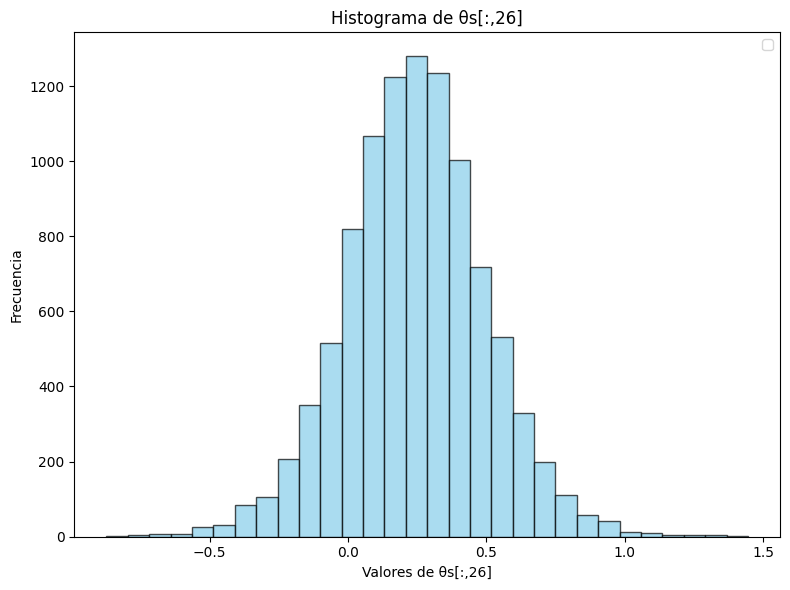

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(θs[:, 25], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel("Valores de θs[:,26]")
plt.ylabel("Frecuencia")
plt.title("Histograma de θs[:,26]")
plt.legend()
plt.tight_layout()
plt.show()

## Graph some $\lambda$ simulations 

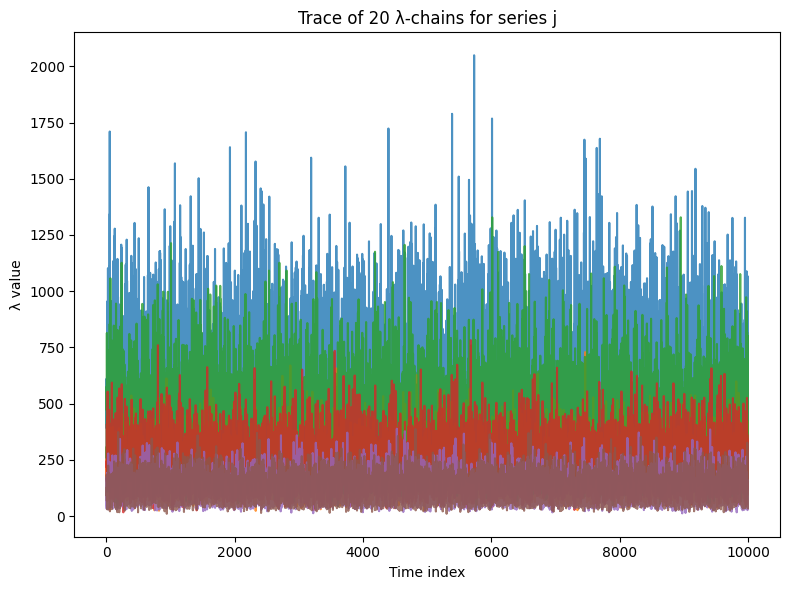

In [9]:
T, R = λs.shape
n_chains = min(20, R)
chains = np.random.choice(R, size=n_chains, replace=False)

plt.figure(figsize=(8, 6))
for c in chains:
    plt.plot(np.arange(T), λs[:, c], alpha=0.8)
plt.title("Trace of 20 λ‐chains for series j")
plt.xlabel("Time index")
plt.ylabel("λ value")
plt.tight_layout()
plt.show()

- **lambdas**: an $R\times q$ array where each element $\lambda_j^{(r)}$ is a Monte Carlo draw of the observation‐noise precision for series $j$ in replicate $r$. Higher $\lambda$ means lower assumed noise variance for that series.  
- **thetas**: an $R\times p_{\text{total}}$ array where each row $\theta^{(r)}$ is a full draw of the VAR($p$) state vector at time $t$, stacking all intercepts, own‐lags, cross‐lags and any exogenous dummies. You can reshape each $\theta^{(r)}$ into the time‐varying coefficient matrices $A_{t,1},\dots,A_{t,p}$ that define the joint VAR dynamics.  



## Predict the entire series with the model and the coupled posterior: $y^* = F\theta^*$

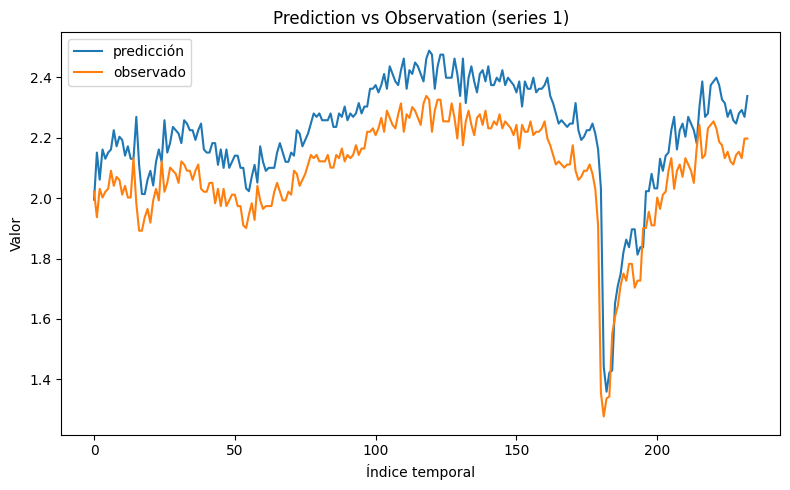

In [10]:
theta_s_un = θs[:, pdims[0] : pdims[1]].mean(axis=0) ## Calculate the mean of the posterior
F_un= Fj_matrix_covid(Y,p,1,Windx,covid_periods,indx_covid,q)
m_un=m[1+pdims[0]:pdims[1]]
y1_un=F_un*theta_s_un ## We make the prediction


pred1 = y1_un[:, 1]    
actual1 = yy[p:, 0] 

plt.figure(figsize=(8, 5))
plt.plot(pred1, label="predicción")
plt.plot(actual1, label="observado")
plt.xlabel("Índice temporal")
plt.ylabel("Valor")
plt.title("Prediction vs Observation (series 1)")
plt.legend()
plt.tight_layout()
plt.show()

## Getting started with the algorithm for VB used in the Decoupling step:

In [11]:
def convert_gamma(theta_s, pdims, Windx, covid_periods, q, p):
    """
    Compute importance‐sampling weights α based on simultaneous‐interaction coefficients γ.

    For each Monte Carlo draw r of the full state vector θ_s[r]:
      1. Extract all simultaneous‐interaction coefficients γ_j for each series j:
         - Each block θ_s[r, pdims[j]:pdims[j+1]] contains [own‐lags; pandemic dummies; γ_j].
         - γ_j are the entries from index p_phi to end of that block.
      2. Stack γ_j from j=1…q into one long vector gamma_vec.
      3. Form the q×q simultaneous‐dependence matrix Γ_t = I_q with off‐diagonals:
         Γ_t[i,j] = –γ_vec[k] wherever Windx[i,j] is True (i≠j).
      4. Compute α_r = |det(Γ_t)|, the absolute determinant correction (see eqs. 11–12 of Gruber & West).
      5. Normalize all α_r so they sum to 1.
    Returns:
      alphas_normed : length-R array of normalized importance weights α_r.
    """
     
    R = theta_s.shape[0]
    p_phi = 1 + q*p + covid_periods # length of each block before simultaneous coefficients
    mask = Windx.astype(bool).T  # boolean mask for off‐diagonal entries in Γ_t
    alphas = np.zeros(R)
    Iq = np.eye(q)

    for r in range(R):
        # 1) collect all γ_j from each series block
        gamma_vec = []
        for j in range(q):
            start, stop = pdims[j], pdims[j+1]
            block = theta_s[r, start:stop]
            gamma_j = block[p_phi:]           # simultaneous coeffs for series j
            gamma_vec.append(gamma_j)
        gamma_vec = np.hstack(gamma_vec)   

        # 2) build Γ_t = I_q plus off‐diagonals = –γ entries
        Γt = Iq.copy()
        Γt[mask] = -gamma_vec

        # 3) compute weight = |determinant of Γ_t|
        alphas[r] = abs(np.linalg.det(Γt))

    # 4) normalize weights for importance sampling
    return alphas / alphas.sum()

alphast = convert_gamma(θs,pdims,Windx,covid_periods,q,p)


def exp_lambda(alphas,λs,q):
    """
    Compute the posterior expectation of each observation‐noise precision λ_j
    after recoupling, using importance weights α_r.

    The expectation for series j is:
        E[λ_j] = Σ_{r=1}^R α_r * λ_{r,j}

    Args:
      alphas : array of length R containing normalized importance weights α_r
      λs     : array (R × q) of sampled precisions λ_{r,j}
      q      : number of series

    Returns:
      Elambda: (q × 1) array where each entry Elambda[j] is the weighted average
               of the R draws for λ_j.
    """

    Elambda = np.zeros((q,1))

    # for each series j, compute weighted sum of its R draws
    for i in range(q):
        Elambda[i]= np.sum(alphas* λs[:,i]) # E[λ_j] = Σ α_r λ_{r,j}
    return Elambda

Eλt = exp_lambda(alphast,λs,q)

def m_vector(pdims, θs, λs, alphas, p_total, q, Eλ):
    """
    Compute the VB prior mean vector m after recoupling and importance‐weighting.

    For each series j = 1…q:
      1. Extract the block θs[:, start:end] of shape (R × p_j), containing R draws of that series’ coefficients.
      2. Weight each draw by its precision λs[r, j].
      3. Compute the weighted sum across draws with importance weights α_r:
         numer_j = Σ_{r=1}^R α_r · [λ_{r,j} · θs[r, start:end]]
      4. Normalize by E[λ_j] to obtain
         m_j = numer_j / Eλ[j]

    This implements the VB update m_j = E[λ_j θ_j] / E[λ_j] (see Gruber & West).
    Returns:
      m : (p_total × 1) VB prior mean vector for the next iteration.
    """

    R = θs.shape[0]
    m = np.zeros((p_total, 1))


    for j in range(q):
        start, end = pdims[j], pdims[j+1]
        # R × p_j block of draws for series j
        block = θs[:, start:end]               
        # weight each draw by its λs value
        weighted = block * λs[:, j].reshape(R, 1)

        # importance‐weighted sum: (1 × R) @ (R × p_j) = (1 × p_j)
        numer = alphas.reshape(1, R) @ weighted  # (1 × pj)
        # normalize by E[λ_j]
        m[start:end, 0] = (numer / Eλ[j]).flatten() 
    return m

m_t=m_vector(pdims,θs,λs,alphast,p_total,q,Eλt)

def V_matrix(pdims,alphas,θs,λs,m,j):
    """
    Compute the VB‐approximated prior covariance block V_j for node j after recoupling.

    Implements the expectation
        V_j = E[ λ_j · (θ_j − m_j)(θ_j − m_j)ᵀ ]
    using R Monte Carlo samples and normalized importance weights α_r.

    - θs[r, pdims[j]:pdims[j+1]] : the r-th draw of the full state vector for node j
    - m[pdims[j]:pdims[j+1]]     : the VB mean vector m_j for node j
    - λs[r, j]                   : the r-th draw of the precision λ_j
    - alphas[r]                  : the r-th normalized importance weight α_r

    The block dimension is pj = pdims[j+1] − pdims[j].

    Returns:
      V : (pj × pj) covariance matrix for node j
    """
    
    R = len(alphas)
    pj = -(pdims[j] - pdims[j+1])
    V = np.zeros((pj,pj))

    mm = m[pdims[j]:pdims[j+1]] # extract VB mean for block j
    err = θs[:,pdims[j]:pdims[j+1]] - mm.T # compute deviations for each sample: shape (R, pj)
    G = np.empty_like(V)  # temporary buffer for outer product
    
    for i in range(R):
        err_r = err[i,:]
        np.multiply.outer(err_r, err_r, out=G) # compute (θ_r − m)(θ_r − m)ᵀ in-place
        V = V + alphas[i] * (λs[i,j] * G) # weight by α_r and λ_{r,j}
    return V 

Vt1=V_matrix(pdims,alphast,θs,λs,m_t,0)


def d_matrix(pdims,alphas,θs,λs,m,V,j):
    """
    Compute the VB Mahalanobis‐distance term D_j for node j after recoupling.

    This implements the expectation needed to update the degrees of freedom in VB:
        D_j = E[λ_j · (θ_j − m_j)ᵀ · V_j⁻¹ · (θ_j − m_j)]
            = Σ_{r=1}^R α_r · λ_{r,j} · (θ_{r,j} − m_j)ᵀ · V_j⁻¹ · (θ_{r,j} − m_j)
    Returns:
      V : (p_j × p_j) VB prior covariance matrix for series j.
    """

    R = len(alphas)
    D=0
    # Invert the covariance block
    iV = np.linalg.inv(V)

    # Extract VB mean for node j
    mm = m[pdims[j]:pdims[j+1]]

    # Deviations of each draw: θ_{r,j} − m_j
    err = θs[:,pdims[j]:pdims[j+1]] - mm.T

    # Accumulate α_r · λ_{r,j} · err_rᵀ iV err_r
    for i in range(R):
        err_r = err[i,:]
        D = D + alphas[i] * λs[i,j] * (err_r.T @ iV @ err_r) # (err_r.T @ iV @ err_r) is precisely the Mahalanobis distance of the vector err with the covariance matrix
    return D 

d1t = d_matrix(pdims,alphast,θs,λs,m_t,Vt1,0)

### Small explanation of D:

$$
D_j \;=\;
\sum_{r=1}^R
\underbrace{\alpha_r}_{\substack{\text{importance}\\\text{sampling weight}}}
\;\;
\underbrace{\lambda_{r,j}}_{\substack{\text{precision}\\\text{of series }j}}
\;\;
(\theta_j^{(r)} - m_j)^\top
\underbrace{V_j^{-1}}_{\substack{\text{inverse of}\\\text{VB covariance}}}
\;
(\theta_j^{(r)} - m_j)
$$

where:

- $\alpha_r$ is the normalized importance sampling weight for draw $r$,  
- $\lambda_{r,j}$ is the precision of series $j$ in draw $r$,  
- $\theta_j^{(r)}$ is the parameter vector for series $j$ in draw $r$,  
- $m_j$ is the VB prior mean vector for block $j$,  
- $V_j$ is the VB covariance matrix for block $j$.  


In [14]:
from scipy.special import digamma, polygamma
from scipy.optimize import newton

def n_solve(pdims, d, alphas, lambdas, j, E_lambda):
    """
    Solve for the posterior degrees‐of‐freedom n_{j,t} in the VB update.

    We find n > 0 satisfying the West & Harrison equation for node j:
        log(n + p_j – d) – ψ(n/2) – log(2 · E[λ_j]) + E[log λ_j] – (p_j – d)/n = 0

    using the substitution x = log(n) and Newton–Raphson.
    Returns:
      n_jt      : positive scalar solution for the degrees‐of‐freedom at time t
    """

    # block dimension for node j
    pj = pdims[j+1] - pdims[j]

    # compute E[log λ_j] under importance weights
    log_lambda_j = np.log(lambdas[:, j])
    Elog_lambda_j = np.sum(alphas * log_lambda_j)

    # define target function in x = log(n)
    def f(x):
        n = np.exp(x)
        return ( np.log(n + pj - d)- digamma(n/2)- np.log(2 * E_lambda[j])+ Elog_lambda_j- (pj - d) / n )

    # derivative f'(x) for Newton’s method
    def fprime(x):
        n = np.exp(x)
        return n * ( 1/(n + pj - d)- 0.5 * polygamma(1, n/2)+ (pj - d) / (n**2) )

    # initial guess x0 = log(5)
    x0 = np.log(5.0)
    x_star = newton(f, x0, fprime, tol=1e-8, maxiter=50)
    return np.exp(x_star)

def s_sol(pdims,dj,Eλ,nj,j):
    """
    Compute the posterior scale parameter s_j for series j in VB.

    Implements the West & Harrison VB formula for the Gamma posterior scale:
        s_j = (n_j + p_j – d_j) / (n_j · E[λ_j])

    where:
      - n_j      : updated degrees of freedom for series j
      - p_j      : number of parameters in block j = pdims[j+1] – pdims[j]
      - d_j      : weighted Mahalanobis trace for block j
      - E[λ_j]   : expected precision for series j

    The outcome s_j controls the residual variance in the univariate model after recoupling and decoupling using VB.
    Returns:
      s_j   : posterior Gamma scale parameter controlling residual variance
    """

    pj = pdims[j+1] - pdims[j] # dimensión del bloque de parámetros para la serie j
    return (nj+pj-dj) / (nj * Eλ[j]) # aplicación directa de la fórmula VB para s_j



## Variational Bayes Update Functions

All of the following routines that we just run implement the **VB update** after recoupling:

- **`convert_gamma(theta_s, pdims, Windx, covid_periods, q, p)`**  
  Computes importance‐sampling weights  
  $$
    \alpha_r = \bigl|\det(\Gamma_t)\bigr|,
  $$  
  where $\Gamma_t = I_q$ with off-diagonals $-\gamma$ extracted from each draw $\theta_s[r]$.

- **`exp_lambda(alphas, λs, q)`**  
  Computes the posterior expectation  
  $$
    E[\lambda_j] \;=\;\sum_{r=1}^R \alpha_r\,\lambda_{r,j}
  $$  
  for each series $j$.

- **`m_vector(pdims, θs, λs, alphas, p_total, q, Eλ)`**  
  Builds the VB prior mean via  
  $$
    m_j \;=\;\frac{\sum_{r=1}^R \alpha_r\,\lambda_{r,j}\,\theta_{r,j}}{E[\lambda_j]},
  $$  
  stacking all $m_j$ into a $(p_{\rm total}\times1)$ vector.

- **`V_matrix(pdims, alphas, θs, λs, m, j)`**  
  Constructs the VB covariance block  
  $$
    V_j \;=\;\sum_{r=1}^R \alpha_r\,\lambda_{r,j}\,(\theta_{r,j}-m_j)\,(\theta_{r,j}-m_j)^\top.
  $$

- **`d_matrix(pdims, alphas, θs, λs, m, V, j)`**  
  Computes the Mahalanobis term  
  $$
    D_j \;=\;\sum_{r=1}^R \alpha_r\,\lambda_{r,j}\,(\theta_{r,j}-m_j)^\top V_j^{-1}(\theta_{r,j}-m_j).
  $$

- **`n_solve(pdims, d, alphas, λs, j, Eλ)`**  
  Solves for the VB degrees of freedom $n_{j,t}>0$ by Newton–Raphson on  
  $$
    \log(n + p_j - d_j) - \psi\!\bigl(\tfrac n2\bigr) - \log\bigl(2\,E[\lambda_j]\bigr) + E[\log\lambda_j] - \frac{p_j-d_j}{n} = 0.
  $$

- **`s_sol(pdims, d_j, Eλ, n_j, j)`**  
  Computes the posterior scale  
  $$
    s_j \;=\;\frac{n_j + p_j - d_j}{n_j\,E[\lambda_j]},
  $$  
  which sets the residual‐variance parameter in the VB step.



## Decopuling Function: 

In [ ]:
def decoupling(pdims, theta_s, lambda_s, alphas, p_total, E_lambda, q):
    """
    Perform the VB decoupling step after recoupling.
    Given:
      - theta_s   : (R × p_total) Monte Carlo draws of the full state vector θ.
      - lambda_s  : (R × q) draws of observation‐noise precisions λ_{r,j}.
      - alphas    : (R,) normalized importance weights α_r.
      - E_lambda  : (q × 1) posterior expectations E[λ_j].
      - pdims     : partition indices delimiting each series’ parameter block in θ.
      - q         : number of series.
      - p_total   : total number of parameters across all series.

    Computes VB priors for the next period:
      - m : (p_total × 1) mean vector, where for each block j:
          m_j = \frac{\sum_{r=1}^R \alpha_r\,\lambda_{r,j}\,\theta_{r,j}}{E[\lambda_j]}

      - C : (p_total × p_total) block-diagonal covariance, with each block
          V_j = \sum_{r=1}^R \alpha_r\,\lambda_{r,j}\,(\theta_{r,j}-m_j)(\theta_{r,j}-m_j)^\top,\quad
          C_j = s_j\,V_j

      - n : (q × 1) updated degrees-of-freedom for each series, solving
          \log(n_j + p_j - d_j) - \psi\!\bigl(\tfrac{n_j}{2}\bigr) - \log\bigl(2\,E[\lambda_j]\bigr) + E[\log \lambda_j]
          - \frac{p_j - d_j}{n_j} = 0

      - s : (q × 1) scale parameters
          s_j = \frac{n_j + p_j - d_j}{n_j\,E[\lambda_j]}.
    Returns:
      m, C, n, s
    """
    C = np.zeros((p_total, p_total))
    n = np.zeros((q, 1))
    s = np.zeros((q, 1))

    # 1) Compute VB prior mean vector m_j = E[θ_j] / E[λ_j]
    m = m_vector(pdims, theta_s, lambda_s, alphas, p_total, q, E_lambda)

    # 2) For each series j, build covariance block and update n_j, s_j
    for j in range(q):
        start, end = pdims[j], pdims[j+1]
        Vj = V_matrix(pdims, alphas, theta_s, lambda_s, m, j)  # 2.1) VB covariance block V_j
        dj = d_matrix(pdims, alphas, theta_s, lambda_s, m, Vj, j) # 2.2) Mahalanobis term d_j for df update
        nj_val = n_solve(pdims, dj, alphas, lambda_s, j, E_lambda) # 2.3) Solve for VB degrees of freedom n_j
        n[j, 0] = nj_val

        sj_val = s_sol(pdims, dj, E_lambda, nj_val, j) # 2.4) Compute scale s_j
        s[j, 0] = sj_val 

        # 2.5) Fill block in global covariance matrix
        C[start:end, start:end] = Vj * sj_val

    #m: the column vector of approximate posterior means, concatenated for each series j
    #C: the approximate posterior covariance matrix, constructed block by block as Cj = Vj * sj
    #n: the vector with the degrees of freedom for each series
    #s: the vector of scales sj

    return m, C, n, s

m,C,n,s = decoupling(pdims,θs,λs,alphast,p_total,Eλt,q)

## VB Decoupling: Outcome and Key Equations

After recoupling, the VB decoupling step produces updated variational parameters for each series $j$:

- **Mean update**  
  $$
    m_j \;=\;\frac{\sum_{r=1}^R \alpha_r\,\lambda_{r,j}\,\theta_{r,j}}{E[\lambda_j]}
  $$

- **Covariance update**  
  $$
    C_j \;=\; s_j \sum_{r=1}^R \alpha_r\,\lambda_{r,j}\,
      (\theta_{r,j}-m_j)\,(\theta_{r,j}-m_j)^\top
  $$

- **Degrees of freedom**  
  Solve for $n_j>0$ in
  $$
    \log(n_j + p_j - d_j)\;-\;\psi\!\bigl(\tfrac{n_j}{2}\bigr)
    \;-\;\log\bigl(2\,E[\lambda_j]\bigr)
    \;+\;E[\log\lambda_j]
    \;-\;\frac{p_j - d_j}{n_j} \;=\;0
  $$

- **Scale parameter**  
  $$
    s_j \;=\;\frac{n_j + p_j - d_j}{n_j\,E[\lambda_j]}
  $$

By computing these VB priors $(m_j, C_j, n_j, s_j)$ for each univariate DLM, we prepare the updated priors that will be used in the **next decoupling step**—where each series is re-filtered in parallel with its new prior—and then recoupled again. This completes one full decouple–recouple–VB cycle, enabling the VAR coefficients to evolve adaptively over time. 



## Now that we have defined the *Recopuling* and *Decopuling* functions with importance sampling and VB we can do: MCMC FORWARD INFERENCE

In [16]:
def mcmc_forward(R, β, δϕ, δγ, λ0, s2, rho, pdims, Y, p, q, Windx, covid_periods, indx_covid, p_total):
    """
    Run the full forward MCMC/VB filtering for the SGDLM-VAR over all time points.

    This routine performs the three-stage decouple–recouple–VB cycle at each time step:

    1) **Initialize Priors**  
       - Call `complete_AP` to get the Minnesota‐style priors (m, C, n, s) and partition indices pdims.  
       - Compute total parameter dimension p_total via `full_size`.

    2) **Prepare Data**  
       - Drop the first p rows of Y to align lags, yielding y of shape (T, q).

    3) **Preallocate Storage**  
       - Θs: array of shape (p_total, T, R) for MCMC draws of the state vector θ_t.  
       - Λs: array of shape (q, T, R) for MCMC draws of the noise precision λ_t.

    4) **Loop over time t = 0…T–1**  
       a) **Recoupling** (`recoupling`):  
          Draw R joint samples (θs, λs) from the current priors (m, C, n, s) and data at time t.  
       b) **Store**  
          Save θs and λs into Θs and Λs for this time index.  
       c) **Compute Importance Weights**  
          Use `convert_gamma_sign_soft` to get α_r for each draw.  
       d) **Posterior λ Expectation**  
          Compute E[λ_j] via `exp_lambda`.  
       e) **VB Decoupling** (`decoupling`):  
          Update variational parameters (m, C, n, s) for the next time step.

    Returns:
      Θs : numpy array (p_total × T × R) of MCMC samples for θ over all times.
      Λs : numpy array (q × T × R) of MCMC samples for λ over all times.
    """

    # 1) Initialize priors
    m, C, n, s, pdims = complete_AP(q, p, λ0, s2, rho, covid_periods, Windx, Y)
    p_total = full_size(Y, p, Windx, covid_periods, indx_covid, q)

    # 2) Align data by dropping initial p rows
    y = Y[p:, :]
    T = y.shape[0]

    # 3) Allocate output arrays
    Θs = np.zeros((p_total, T, R))
    Λs = np.zeros((q, T, R))

    for t in range(T):

        # a) Recoupling: draw R samples of θ_t and λ_t
        θs, λs = recoupling(R, β, δϕ, δγ, m, C, n, s,pdims, t, Y, p, Windx,covid_periods, indx_covid, p_total)

         # b) Store draws
        Θs[:, t, :] = θs.T
        Λs[:, t, :] = λs.T

        # c) Compute importance weights
        alphas = convert_gamma(θs, pdims, Windx, covid_periods, q, p) 

        # d) Compute posterior expectation of λ
        Eλ     = exp_lambda(alphas, λs, q)

        # e) VB decoupling: update priors for next t
        m, C, n, s = decoupling(pdims, θs, λs, alphas, p_total, Eλ, q)

    return Θs, Λs

θss,λss = mcmc_forward(2000,β,δϕ,δγ,λ,s2,rho,pdims,Y,p,q,Windx,covid_periods,indx_covid,p_total)

---

## Overall Workflow in the MCMC 

At each time step $t$, we execute the following three‐stage cycle to learn a dynamic VAR($p$) via SGDLM‐VB:

1. **Decoupling (Univariate DLM Filters)**  
   - For each series $j=1,\dots,q$:  
     - Build the design vector $F_{j,t}$ that includes its $p$ own‐lags, the $p$ cross‐lags of all other series, and any COVID dummies.  
     - Evolve the prior $(m_{j,t-1},C_{j,t-1})$ via discount factors $\phi,\gamma$ (`pred_θj`).  
     - Perform the one‐step DLM update (`prxy_updating`) to get the forecast gain, error, and updated scale parameters.  
     - Draw $R$ samples of $\lambda_{j}$ (`proxy_lambdj`) and then sample $\theta_{j,t}$ (`proxy_theta_j2`).  
   - This yields $q$ blocks of Monte Carlo samples $\{\theta_{j,t}^{(r)},\lambda_{j}^{(r)}\}_{r=1}^R$.

2. **Recoupling (Monte Carlo Combination)**  
   - Compute importance weights  
     $
       \alpha_r \;=\;\bigl|\det(I_q - \Gamma_t^{(r)})\bigr|
     $  
     via `convert_gamma`, where $\Gamma_t$ is built from the $\gamma$-blocks of each $\theta^{(r)}$.  
   - Normalize $\{\alpha_r\}$.  
   - Stack each $\theta_{j,t}^{(r)}$ into a full vector $\theta_t^{(r)}$, giving $R$ draws of the joint state.  
   - These draws represent a **time‐varying VAR**  
     $
       y_t = A_{t,1}\,y_{t-1} + \cdots + A_{t,p}\,y_{t-p} + \varepsilon_t,
     $  
     with dynamic coefficient matrices $A_{t,k}$ extracted from $\theta_t^{(r)}$.

3. **VB Decoupling (Approximate Posterior → Next Priors)**  
   - Compute $E[\lambda_j]$ via `exp_lambda`.  
   - Form the VB mean vector $m_j = \sum_r \alpha_r\,\lambda_{r,j}\,\theta_{j,t}^{(r)} \,/\,E[\lambda_j]$` (`m_vector`).  
   - Build each VB covariance block  
     $
       V_j = \sum_r \alpha_r\,\lambda_{r,j}\,(\theta_{j,t}^{(r)}-m_j)(\theta_{j,t}^{(r)}-m_j)^\top
     $  
     (`V_matrix`).  
   - Compute the Mahalanobis term $d_j$ (`d_matrix`), solve for VB degrees of freedom $n_j$ (`n_solve`), and scale $s_j=(n_j+p_j-d_j)/(n_j\,E[\lambda_j])$ (`s_sol`).  
   - Assemble the global priors $(m,C,n,s)$ block‐by‐block for time $t+1$.

These updated priors feed into the next iteration’s decoupling, completing the decouple–recouple–VB cycle and delivering a fast, scalable algorithm for dynamic VAR modeling. 

---

## We check the dimensions of the estimated parameters:

In [17]:
print(f'Las dimensiones de θ son {θss.shape}')
print(f'Las dimensiones de λ son {λss.shape}')

Las dimensiones de θ son (167, 233, 2000)
Las dimensiones de λ son (6, 233, 2000)



## Check the results:

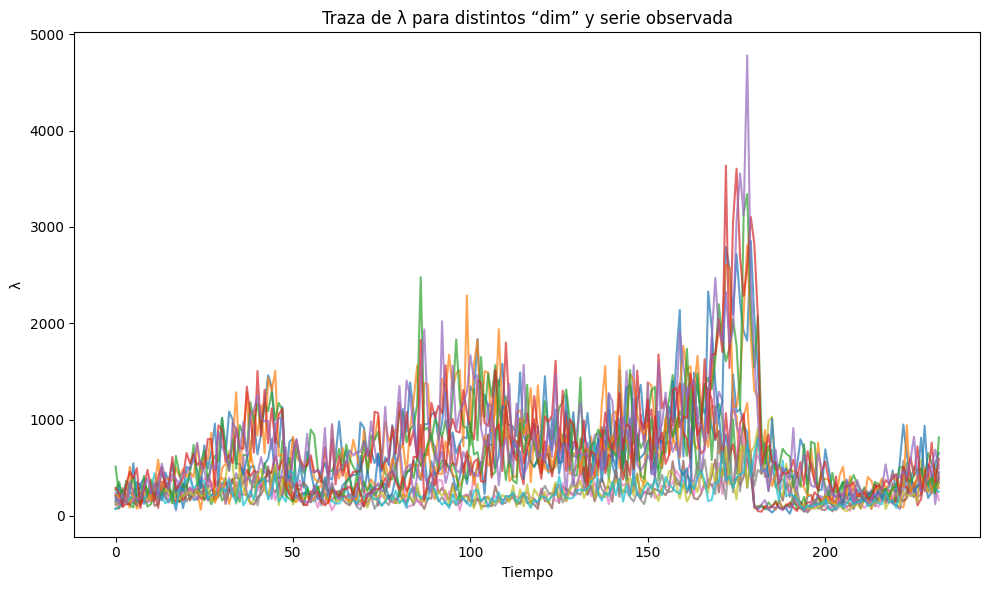

In [30]:

slice_dim2 = λss[0, :, 40:45]  
slice_dim3 = λss[1, :, 40:45]
slice_dim6 = λss[2, :, 40:45]

plt.figure(figsize=(10, 6))
plt.plot(slice_dim2,   alpha=0.7)
plt.plot(slice_dim3,   alpha=0.7)
plt.plot(slice_dim6,   alpha=0.7)
plt.xlabel('Tiempo')
plt.ylabel('λ')
plt.title('Traza de λ para distintos “dim” y serie observada')
plt.tight_layout()
plt.show()


## Check the posterior of some parameter θ


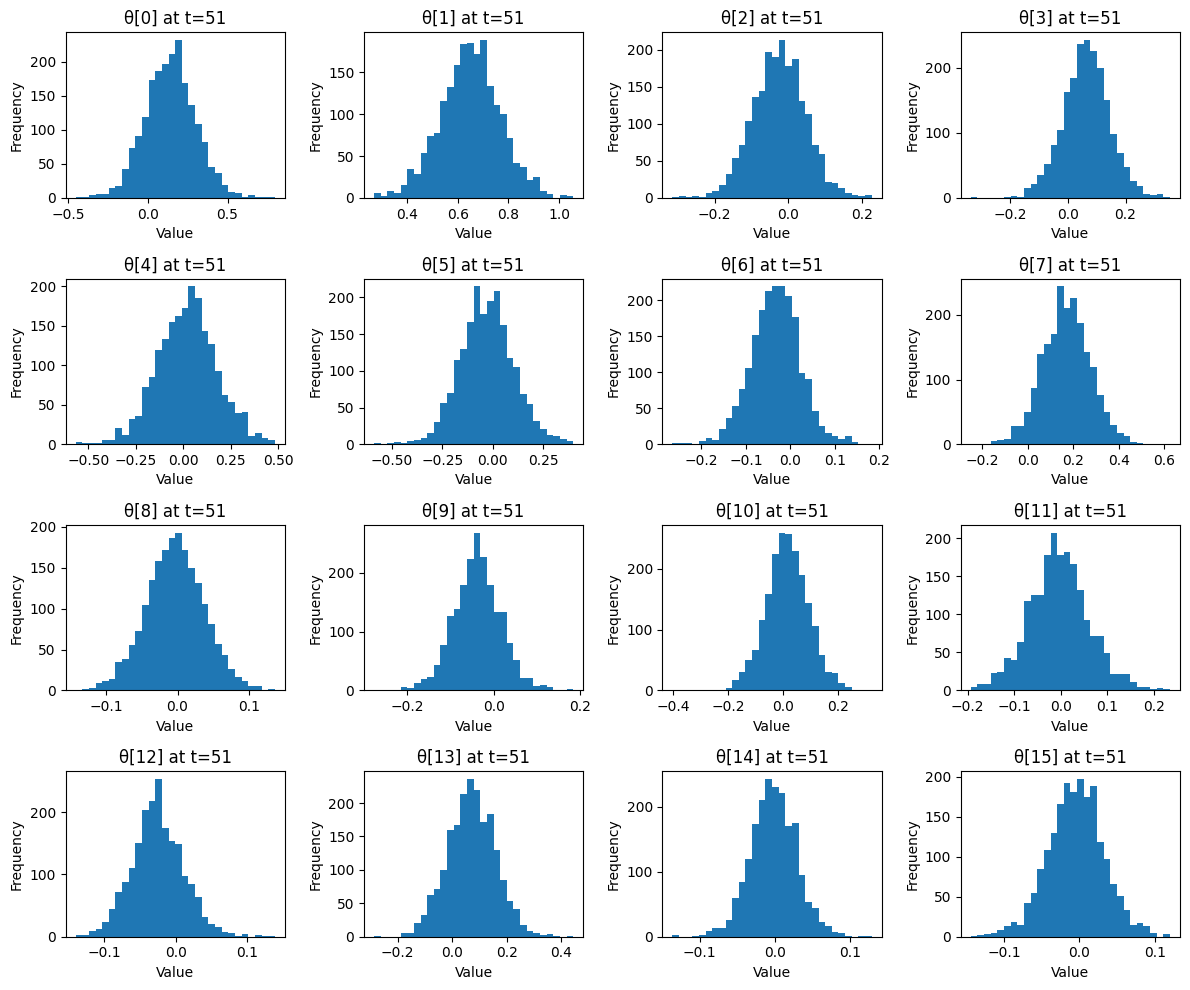

In [26]:

# θss is your array of shape (p_total, T, R)
# Choose a time index t and a list of parameter indices to display
time_idx = 51
param_indices = list(range(16))  # for example, first 16 parameters

n_rows, n_cols = 4, 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 10))

for ax, idx in zip(axes.flatten(), param_indices):
    # extract R samples for parameter idx at time t
    samples = θss[idx, time_idx, :]
    ax.hist(samples, bins=30 )
    ax.set_title(f'θ[{idx}] at t={time_idx}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()



## Model prediction on the first series:

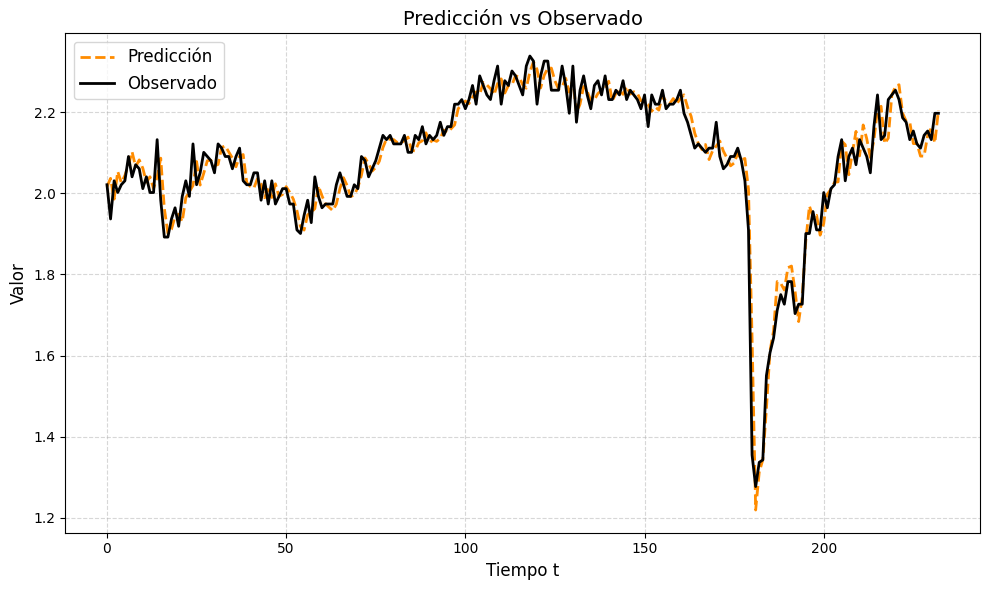

In [21]:
θ_m = np.zeros((θss.shape[1],θss.shape[0]))
for i in range(θss.shape[1]):
    for k in range(θss.shape[0]):
        θ_m[i,k] = np.mean(θss[k,i,:])

F_un=Fj_matrix_covid(Y,p,1,Windx,covid_periods,indx_covid,q)
ee= np.zeros(θss.shape[1])

for t in range(θss.shape[1]):
    ee[t] = F_un[t,:].T @ θ_m[t ,0:pdims[1]]

plt.figure(figsize=(10, 6))
plt.plot(ee, color='darkorange', linewidth=2, label='Predicción' , linestyle='--')

plt.plot(yy[p:, 0], color='black', linewidth=2, label='Observado')

plt.fill_between(
    range(len(ee)), ee, yy[p:, 0],
    where=(ee > yy[p:, 0]),
    facecolor='orange', alpha=0.1,
    interpolate=True
)
plt.fill_between(
    range(len(ee)), ee, yy[p:, 0],
    where=(ee <= yy[p:, 0]),
    facecolor='gray', alpha=0.1,
    interpolate=True
)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.xlabel('Tiempo t', fontsize=12)
plt.ylabel('Valor', fontsize=12)
plt.title('Predicción vs Observado', fontsize=14)
plt.tight_layout()

plt.show()

##  k‑step‑ahead forecasting out‑of‑sample

In [ ]:
def idx_col_major(mask):
    """
    Convert a boolean mask into column-major (Fortran-style) index order.

    This helper takes a 2D boolean array `mask` and returns the row and column
    indices of all True entries in the order you would iterate over columns
    first (column-major order). 
    Returns:
      (rows, cols) : two 1D arrays of equal length, giving the positions of True
                     entries in column-first order.
    """
    rows, cols = np.nonzero(mask)
    order = np.lexsort((rows, cols))  
    return rows[order], cols[order]

def A_matrix(θs, pdims, Windx, covid_periods, q, p, r):
    """
    Build the structural impact matrix A = (I - Gamma')^{-1} for a VAR model.

    Args:
      theta_s       : array (R × p_total) of MCMC draws.
      pdims         : partition indices for each equation's parameter block.
      Windx         : (q×q) boolean mask for contemporaneous parents.
      covid_periods : number of COVID dummy parameters per equation.
      q             : number of series (equations).
      p             : VAR lag order.
      r             : 1-based draw index into theta_s.

    Returns:
      A : (q × q) structural impact matrix = (I - Gamma')^{-1}.
    """

    pphi = q*p + 1 + covid_periods
    Γ = np.eye(q)

    # Collect all contemporaneous gamma coefficients into one vector
    gammas = []
    W_tr=Windx.T
    
    # vector con TODOS los γ
    for j in range(q):
        start, stop = pdims[j], pdims[j+1]
        θj = θs[r-1, start:stop]
        gammas.extend( θj[pphi:] )
    gammas = np.asarray(gammas)

    # Determine positions for off-diagonal entries
    rows, cols = idx_col_major(W_tr)    
    if gammas.size != rows.size:
        raise ValueError("Windx y γ no concuerdan")

    Γ[rows, cols] = -gammas

    # Return the structural impact matrix
    return np.linalg.inv(Γ.T)


def us(θs,Y,pdims,Windx,covid_periods,q,p,r):
    """
    Construct the prediction vector us by accumulating, for each equation i,
    the dot product between the vector of regressors from the last observation
    (constant, p lags for all series and zeros for COVID periods)
    and the corresponding subset of coefficients θs.

    For each i from 0 to q-1:
    1. Extract the last p Y values ​​in reverse order and transpose them,
    flattening them to form the lag regressors.
    2. Prepare fj: a 1 for the intercept, those lags, and zeros to reserve space of length covid_periods.
    3. Count how many contemporaneous parameters are left out (pyj)
    according to the Windx mask in row i.
    4. Select from θs[r] the segment of coefficients φ_j that corresponds
    to equation i, excluding pyj parameters at the end.
    5. Compute us[i] as the dot product between fj and φ_j.

    The result is a column vector us of size q with the predicted
    line
    """
    us = np.zeros((q,1))

    for i in range(q):
        block = Y[-1 : -p-1 : -1, :]
          
        flat_block = block.T.reshape(-1, order='F')
        fj = np.concatenate(([1] ,  flat_block , np.zeros(covid_periods))) # Build regressor f_j: intercept + lags + placeholders for COVID dummies

        pyj = int(np.sum(Windx[i,:])) # Exclude contemporaneous coefficients as indicated by Windx[i]

        phij = θs[r-1, pdims[i]: pdims[i+1]-pyj] # Extract matching slice of phi_j from the state vector for series i

        us[i] = fj.T @ phij  # Compute the forecast for series i
    return us

def osf(mu_s, A_s):
    """
    Compute the structural out-of-sample forecast for all series.

    This function applies the structural impact matrix A_s to the vector of
    one-step ahead predictions mu_s to produce the final forecast.

    Returns:
      o_s : array of shape (q, 1)
        Final out-of-sample forecast combining structural impacts: A_s @ mu_s.
    """
    # Apply structural impact matrix to prediction vector
    o_s = A_s @ mu_s
    return o_s

def cova_f(As, λs, r):
    """
    Compute the structural predictive covariance matrix Σ for draw r.

    This uses the structural impact matrix A_s and the noise precisions λs[r]:
        Σ = A_s · diag(1/λs[r]) · A_sᵀ
    and enforces exact symmetry via eigen‐decomposition.
    Returns:
      Σ   : array (q × q)
        Symmetric predictive covariance matrix for the next observation,
        incorporating contemporaneous and lagged effects.
    """

    # 1) Extract the precision vector for draw r
    inv_lambda = 1.0 / λs[r-1, :]
    D = np.diag(inv_lambda)

    # 2) Form the raw covariance M = A_s · D · A_sᵀ (may be slightly non‐symmetric)
    M = As @ D @ As.T

    # 3) Enforce exact symmetry via eigen‐decomposition
    #    M = V · diag(w) · Vᵀ  → Σ = V · diag(w) · V
    w, v = np.linalg.eigh(M)
    Σ = v @ np.diag(w) @ v.T 
    return Σ

def u_forecast(H, Y, θs, λs, Windx, covid_periods, q, p,
               β, δϕ, δγ, r, pdims, indx_covid, p_total):
    """
    Generate H-step ahead out-of-sample forecasts via decoupling–recoupling.

    At each horizon step i = 0…H-1:
      1. Build structural impact matrix A_s from draw r of θs.
      2. Compute one-step ahead predictions μ_s using the most recent Y and θs[r].
      3. Apply contemporaneous impacts: ỹ = A_s @ μ_s (osf).
      4. Form the predictive covariance Σ = A_s · diag(1/λs[r]) · A_sᵀ (cova_f).
      5. Draw a shock ε ∼ N(0, Σ) via Cholesky, then forecast y_f = ỹ + ε.
      6. Append y_f to Y for the next iteration’s lag alignment.
      7. Recompute importance weights α = convert_gamma(θs…) and E[λ] = exp_lambda(…).
      8. VB decoupling → new priors (m, C, n, s) for the next out-of-sample step.
      9. Recoupling using these priors to redraw θs, λs for the new Y.

    Returns:
      y_pred : array (q × H), simulated out-of-sample forecasts for each series at each horizon step.

    """
    y_pred = np.zeros((q, H))
    
    for i in range(H):
        # 1–3) Structural one-step forecast
        Asf = A_matrix(θs , pdims, Windx, covid_periods, q, p, r) # Structural matrix A 
        mu_f = us(θs, Y, pdims, Windx, covid_periods, q, p, r) # Cumulative predictions 
        myf = osf(mu_f, Asf).flatten() 
        
        # 4) Predictive covariance
        Σ = cova_f(Asf, λs, r)
        L = np.linalg.cholesky(Σ)
        
        # 5) Simulation: add Gaussian shock
        yf = myf + L @ np.random.randn(q)
        y_pred[:, i] = yf
        
        # 6) Update Y with the new forecast
        Y = np.vstack((Y,   yf.reshape(1, -1)))
        y = Y[p:,:]
        T = y.shape[0] - 1
        
        # 7) Compute IS weights and VB moments
        alphas = convert_gamma(θs, pdims, Windx, covid_periods, q, p) 
        Eλ = exp_lambda(alphas, λs, q)
        m, C, n, s = decoupling(pdims, θs, λs, alphas, p_total, Eλ, q)

        # 8) Recouple to redraw θs, λs for the expanded Y
        θs, λs = recoupling(1500, β, δϕ, δγ,m, C, n, s,pdims, T, Y, p,Windx, covid_periods,indx_covid, p_total)

    return y_pred

θ_py = np.transpose(θss, (1, 2, 0))
λ_py = np.transpose(λss, (1, 2, 0))
theta_init  = θ_py[-1, :, :]   
lambda_init = λ_py[-1, :, :]

y_pred = u_forecast(24,Y,theta_init,lambda_init,Windx,covid_periods,q,p,β,δϕ,δγ, 16 , pdims , indx_covid ,p_total)

## Check Results

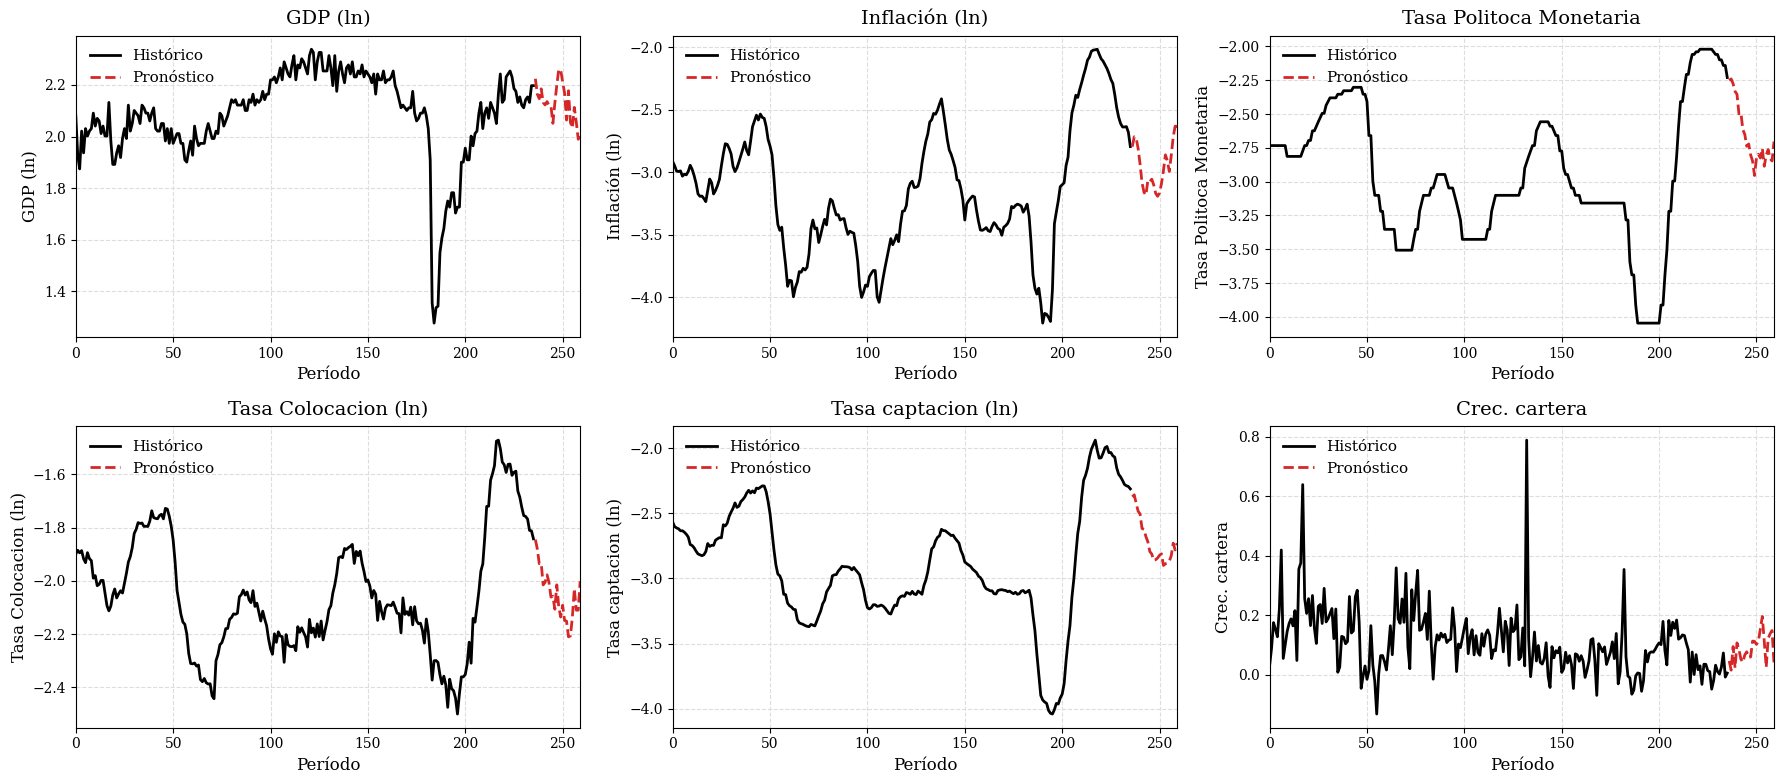

In [43]:
T, q = yy.shape
H = y_pred.shape[1]

x_hist = np.arange(T)
x_fore = np.arange(T, T + H)

labels = [
    'GDP (ln)',
    'Inflación (ln)',
    'Tasa Politoca Monetaria',
    'Tasa Colocacion (ln)',
    'Tasa captacion (ln)',
    'Crec. cartera']

plt.rcParams.update({
    'font.family':       'serif',
    'font.size':         12,
    'axes.titlesize':    14,
    'axes.labelsize':    12,
    'lines.linewidth':   2.0,
    'legend.fontsize':   11,
    'xtick.labelsize':   10,
    'ytick.labelsize':   10,
    'axes.grid':         True,
    'grid.linestyle':    '--',
    'grid.color':        '#dddddd'})

hist_color = 'black'  
pred_color = '#d62728'  

fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()

for i, ax in enumerate(axes[:q]):
    ax.plot(x_hist, yy[:, i], color=hist_color, label='Histórico')
    ax.plot(x_fore, y_pred[i, :], '--', color=pred_color, label='Pronóstico')
    ax.set_title(labels[i], pad=8)
    ax.set_xlim(x_hist[0], x_fore[-1])
    ax.set_xlabel('Período')
    ax.set_ylabel(labels[i])
    ax.legend(frameon=False, loc='upper left')

fig.subplots_adjust(wspace=0.3)
plt.tight_layout()
plt.show()

## Complete predictions

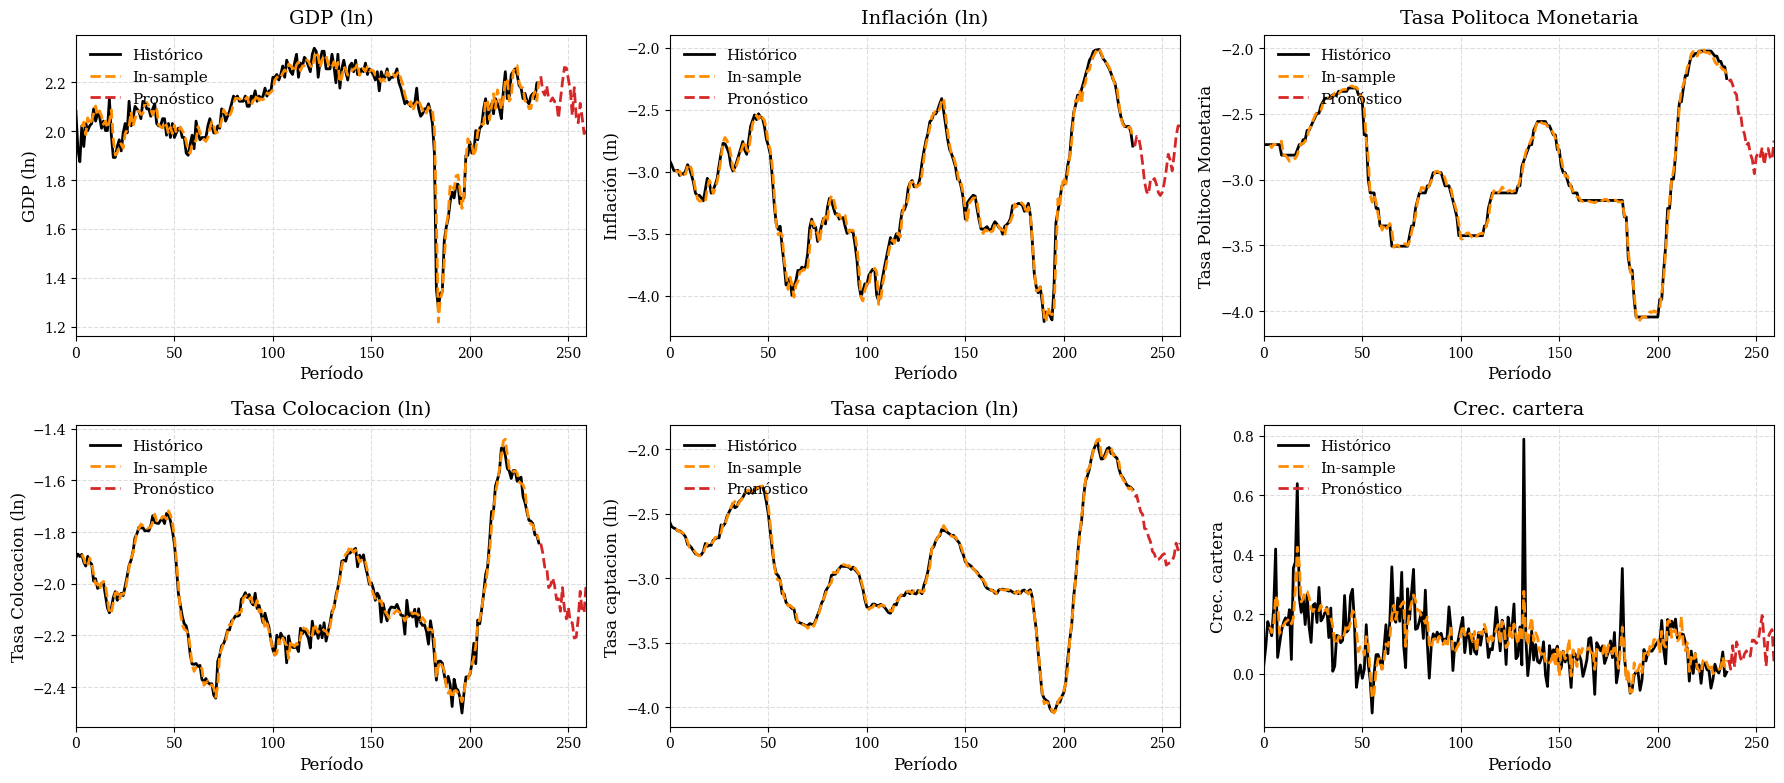

In [47]:
θ_m = θss.mean(axis=2).T          
n_tiempo, total_coef = θ_m.shape
pdims1 = []

for j in range(q):
    F_j = Fj_matrix_covid(Y, p, j+1, Windx, covid_periods, indx_covid, q)
    pdims1.append(F_j.shape[1])
pdims1 = np.asarray(pdims1, int)    

assert pdims1.min()>0, "¡Alguna serie no tiene predictores!"
assert pdims1.sum() == total_coef, (
    f"Suma(pdims1)={pdims1.sum()} ≠ total_coef={total_coef}")

ends   = np.cumsum(pdims1)                   
starts = np.concatenate([[0], ends[:-1]])   
ee = np.zeros((n_tiempo, q))


for j in range(q):
    F_j = Fj_matrix_covid(Y, p, j+1, Windx, covid_periods, indx_covid, q)
    i0, i1 = starts[j], ends[j]
    assert F_j.shape[1] == (i1 - i0), (
        f"Serie {j}: F_j tiene {F_j.shape[1]} cols, "
        f"pero θ_m[:,{i0}:{i1}] son {i1-i0}")

    ee[:, j] = np.sum(F_j * θ_m[:, i0:i1], axis=1)


T, q = yy.shape      
insamp_len = ee.shape[0]  
p = T - insamp_len        

H = y_pred.shape[1]       

x_hist = np.arange(T)
x_ins  = np.arange(p, T)           
x_fore = np.arange(T, T + H)      


plt.rcParams.update({
    'font.family':       'serif',
    'font.size':         12,
    'axes.titlesize':    14,
    'axes.labelsize':    12,
    'lines.linewidth':   2.0,
    'legend.fontsize':   11,
    'xtick.labelsize':   10,
    'ytick.labelsize':   10,
    'axes.grid':         True,
    'grid.linestyle':    '--',
    'grid.color':        '#dddddd'})

hist_color     = 'black'
insample_color = 'darkorange'
pred_color     = '#d62728'

fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.plot(x_hist, yy[:, i],color=hist_color,label='Histórico')

    ax.plot(x_ins, ee[:, i],'--',color=insample_color,label='In‑sample')

    ax.fill_between(x_ins,ee[:, i],yy[p:, i],where=(ee[:, i] > yy[p:, i]),facecolor=insample_color, alpha=0.1,
        interpolate=True)
    ax.fill_between(x_ins,ee[:, i],yy[p:, i],where=(ee[:, i] <= yy[p:, i]),
        facecolor=hist_color, alpha=0.1,interpolate=True)

    ax.plot(x_fore, y_pred[i, :],'--',color=pred_color,label='Pronóstico')

    ax.set_title(labels[i], pad=8)
    ax.set_xlim(x_hist[0], x_fore[-1])
    ax.set_xlabel('Período')
    ax.set_ylabel(labels[i])
    ax.legend(frameon=False, loc='upper left')

fig.subplots_adjust(hspace=0.3, wspace=0.25)
plt.tight_layout()
plt.show()

### Pablo Reyes 